
Descriptive Statistics by Country and Product:

                                               Quantity                   \
                                                   mean         std  sum   
Country     Description                                                    
Australia   10 COLOUR SPACEBOY PEN                 48.0         NaN   48   
            12 PENCIL SMALL TUBE WOODLAND         384.0         NaN  384   
            12 PENCILS TALL TUBE POSY             126.0  161.220346  252   
            12 PENCILS TALL TUBE RED RETROSPOT     12.0         NaN   12   
            16 PIECE CUTLERY SET PANTRY DESIGN     24.0         NaN   24   
...                                                 ...         ...  ...   
Unspecified WRAP POPPIES  DESIGN                   25.0         NaN   25   
            WRAP SUKI AND FRIENDS                  25.0         NaN   25   
            WRAP VINTAGE PETALS  DESIGN            25.0         NaN   25   
            WRAP WEDDING DAY           

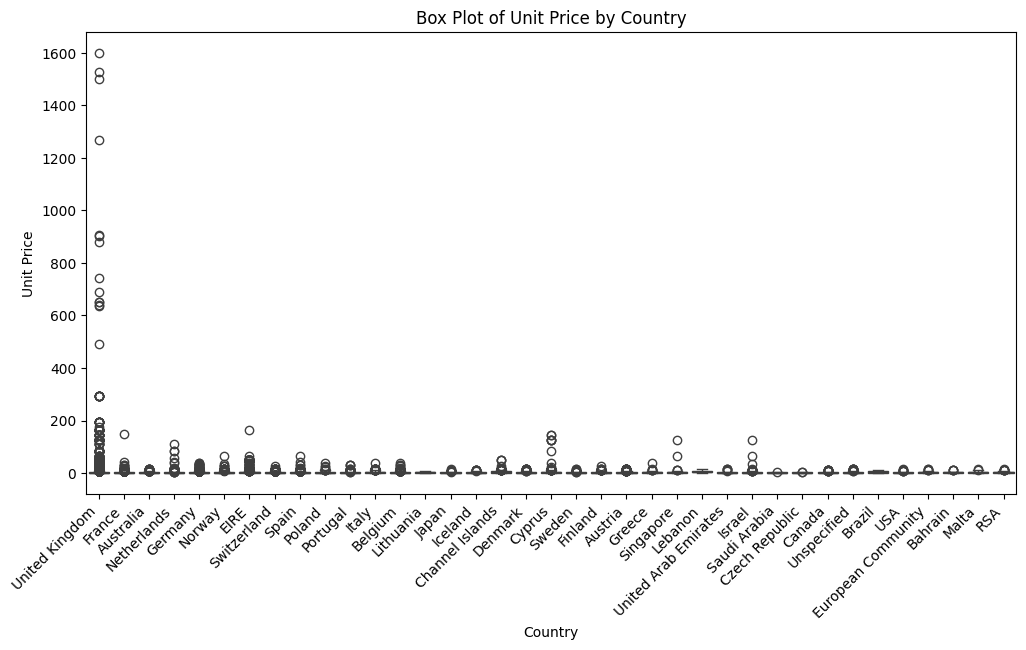

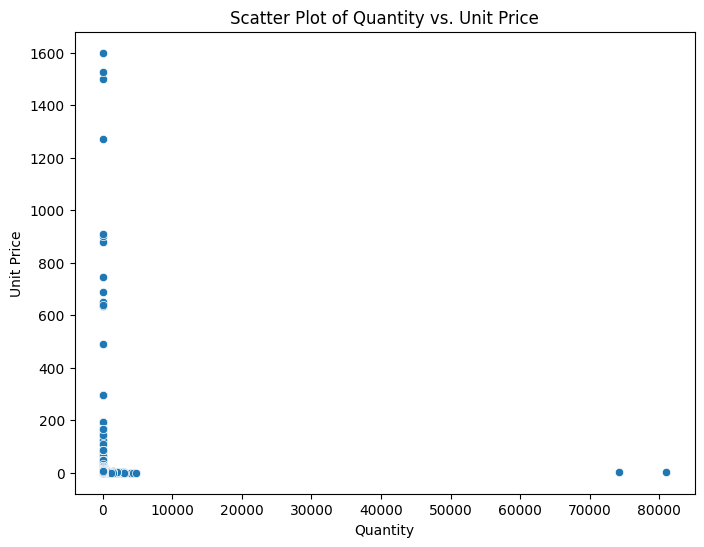


Globally Popular Items:
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
Name: Quantity, dtype: int64

Popular Items in France:
Description
RABBIT NIGHT LIGHT               4000
MINI PAINT SET VINTAGE           2196
RED TOADSTOOL LED NIGHT LIGHT    1291
SET/6 RED SPOTTY PAPER CUPS      1272
ASSORTED COLOUR BIRD ORNAMENT    1204
Name: Quantity, dtype: int64

Popular Items in December:
Description
PAPER CRAFT , LITTLE BIRDIE           80995
WORLD WAR 2 GLIDERS ASSTD DESIGNS      6502
POPCORN HOLDER                         5362
WHITE HANGING HEART T-LIGHT HOLDER     4356
PACK OF 72 RETROSPOT CAKE CASES        3856
Name: Quantity, dtype: int64

Welcome to the Product Recommendation System!

Here are some sample products you can try:
- WHITE HANGING HEART T-LIGHT HOLDER
- WHITE METAL LANTERN
- CREAM CUPID HEAR

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


# Step 1: Load and Clean Data
file_path=("/content/OnlineRetail (1).xlsx")

# Use pd.read_excel to read Excel files
data=pd.read_excel(file_path)

# Clean invalid entries
data.dropna(subset=['CustomerID', 'Description'], inplace=True)
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]
data = data[data['Quantity'] > 0]
data = data[data['UnitPrice'] > 0]

original_descriptions = data['Description'].unique() #to store original descriptions before cleaning(for samples testing)
data = data[~data['Description'].str.upper().isin(['DISCOUNT', 'MANUAL', '', 'SAMPLES', 'POSTAGE'])]

data.loc[:, 'Description'] = data['Description'].str.strip().str.upper()

# Extract month from InvoiceDate
data['InvoiceMonth'] = pd.to_datetime(data['InvoiceDate']).dt.month

# Function to find popular items globally
def find_popular_items_globally(data, top_n=10):
    """Finds the most popular items based on total quantity sold globally."""
    popular_items = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(top_n)
    return popular_items

# Function to find popular items by country
def find_popular_items_by_country(data, country, top_n=10):
    """Finds the most popular items for a specific country."""
    country_data = data[data['Country'] == country]
    popular_items = country_data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(top_n)
    return popular_items

# Function to find popular items by month
def find_popular_items_by_month(data, month, top_n=10):
    """Finds the most popular items for a specific month."""
    month_data = data[data['InvoiceMonth'] == month]
    popular_items = month_data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(top_n)
    return popular_items

# Descriptive Statistics with Pivot Table
country_product_stats = data.pivot_table(
    index=['Country', 'Description'],
    values=['Quantity', 'UnitPrice'],
    aggfunc={'Quantity': ['sum', 'mean', 'std'], 'UnitPrice': ['mean', 'std']}
)

print("\nDescriptive Statistics by Country and Product:\n")
print(country_product_stats)

# Visualization with Seaborn
# Box plot of UnitPrice by Country
plt.figure(figsize=(12, 6))
sns.boxplot(x='Country', y='UnitPrice', data=data)
plt.title('Box Plot of Unit Price by Country')
plt.xlabel('Country')
plt.ylabel('Unit Price')
plt.xticks(rotation=45, ha='right')
plt.show()

# Scatter plot of Quantity vs. UnitPrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Quantity', y='UnitPrice', data=data)
plt.title('Scatter Plot of Quantity vs. Unit Price')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')
plt.show()

# Step 2: Build Customer-Item Interaction Matrix
interaction_matrix = data.pivot_table(
    index='CustomerID',
    columns='Description',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Step 3: Transpose to get Item-Customer Matrix
product_matrix = interaction_matrix.T

# Step 4: Compute Cosine Similarity Between Products
similarity_scores = cosine_similarity(product_matrix)
similarity_df = pd.DataFrame(similarity_scores, index=product_matrix.index, columns=product_matrix.index)

# Step 5: Define Recommendation Function
def recommend_similar_items(item_name, top_n=5):
    item_name = item_name.strip().upper()
    if item_name not in similarity_df.index:
        return f"'{item_name}' not found in product list ."
    recommendations = similarity_df[item_name].sort_values(ascending=False)
    return recommendations[1:top_n+1]

# Example usage of the new functions:
print("\nGlobally Popular Items:")
print(find_popular_items_globally(data, top_n=5))

print("\nPopular Items in France:")
print(find_popular_items_by_country(data, country='France', top_n=5))

print("\nPopular Items in December:")
print(find_popular_items_by_month(data, month=12, top_n=5))

# Step 6: Execution
print("\nWelcome to the Product Recommendation System!\n")

# Provide some sample product names
sample_products = [
    product
    for product in original_descriptions[:10]  # Get the first 10 unique products
    if product.strip().upper() in data['Description'].unique()  # Check if it is in cleaned data
]
print("Here are some sample products you can try:")
for product in sample_products:
    print(f"- {product}")

while True:
    item_name = input("Enter the product name for recommendation from above (or type 'stop' to quit): ")
    if item_name.strip().lower() == 'stop':
        break  # Exit the loop if the user enters 'stop'

    print("\n" + "*" * 50)
    print(f"Recommendations for: {item_name.upper()}")
    print("*" * 50 + "\n")

    recommendations = recommend_similar_items(item_name)
    if isinstance(recommendations, str):  # Check if recommendations is an error message
        print(recommendations)
    else:
        for i, (product, score) in enumerate(recommendations.items(), 1):
            print(f"{i}. {product} (Similarity Score: {score:.4f})")

    print("-" * 50 + "\n")

print("\nThank you for using the recommendation system!")